In [25]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix

## Load Data

In [2]:
X = pd.read_csv('./train.csv', nrows=1000000, parse_dates=['click_time'])

## Preprocessing

In [5]:
y = X['is_attributed']

In [6]:
X['day'] = X['click_time'].dt.date
X['day_hour'] = X['click_time'].dt.floor('h')

## Feature Engineering

### 1. Daily and Hourly ```click count``` per ```IP``` address

In [7]:
df_daily_click_per_ip = X.groupby(['ip', 'day']).agg(daily_click_per_ip=('ip', 'count')).reset_index()
df_hourly_click_per_ip = X.groupby(['ip', 'day_hour']).agg(hourly_click_per_ip=('ip', 'count')).reset_index()

In [8]:
X_all_features = pd.merge(X, df_daily_click_per_ip, on=['ip', 'day'])
X_all_features = pd.merge(X_all_features, df_hourly_click_per_ip, on=['ip', 'day_hour'])

### 2. Daily and Hourly ```click count``` per ```IP``` address and ```app```

In [9]:
df_daily_click_per_ip_app = X.groupby(['ip', 'app', 'day']).agg(daily_click_per_ip_app=('ip', 'count')).reset_index()
df_hourly_click_per_ip_app = X.groupby(['ip', 'app', 'day_hour']).agg(hourly_click_per_ip_app=('ip', 'count')).reset_index()

In [10]:
X_all_features = pd.merge(X_all_features, df_daily_click_per_ip_app, on=['ip', 'app', 'day'])
X_all_features = pd.merge(X_all_features, df_hourly_click_per_ip_app, on=['ip', 'app', 'day_hour'])

### 3. ```Distinct Count``` of ```Devices``` per ```IP``` - Daily and Hourly

In [11]:
df_daily_dist_dev_per_ip = X.groupby(['day', 'ip']).agg(daily_dist_dev_per_ip=('device', 'nunique'))
df_hourly_dist_dev_per_ip = X.groupby(['day_hour', 'ip']).agg(hourly_dist_dev_per_ip=('device', 'nunique'))

In [12]:
X_all_features = pd.merge(X_all_features, df_daily_dist_dev_per_ip, on=['ip', 'day'])
X_all_features = pd.merge(X_all_features, df_hourly_dist_dev_per_ip, on=['ip', 'day_hour'])

### 4. Time till Next Click per ```IP```

In [13]:
ser_till_nextclick_per_ip = X['click_time'] - X.groupby(['ip'])['click_time'].shift()
ser_till_nextclick_per_ip = ser_till_nextclick_per_ip.dt.total_seconds()

In [14]:
X_all_features['till_nextclick_per_ip'] = ser_till_nextclick_per_ip

### 5. Time till Next Click per ```IP``` and ```App```

In [15]:
ser_till_nextclick_per_ip_app = X['click_time'] - X.groupby(['ip', 'app'])['click_time'].shift()
ser_till_nextclick_per_ip_app = ser_till_nextclick_per_ip_app.dt.total_seconds()

In [16]:
X_all_features['till_nextclick_per_ip_app'] = ser_till_nextclick_per_ip_app

## Drop Unnecessary Columns from X_train

In [17]:
ls_all_features = ['daily_click_per_ip', 'hourly_click_per_ip',
                   'daily_click_per_ip_app', 'hourly_click_per_ip_app',
                   'daily_dist_dev_per_ip', 'hourly_dist_dev_per_ip',
                   'till_nextclick_per_ip', 'till_nextclick_per_ip_app']

X_main = X_all_features[ls_all_features]

## Implementing the Algorithms

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_main, y, test_size=0.3, random_state=42, stratify=y
)

### Decision Tree

DT Best Params: {'dt__max_depth': 5}
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    299492
           1       0.01      0.80      0.02       508

    accuracy                           0.87    300000
   macro avg       0.50      0.83      0.48    300000
weighted avg       1.00      0.87      0.93    300000



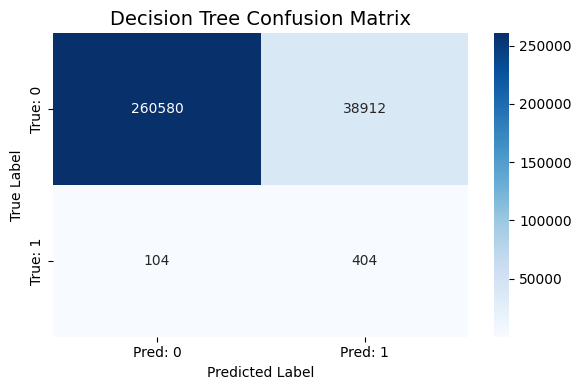

In [29]:
pipeline_dt = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('under', RandomUnderSampler(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    'dt__max_depth': [3, 5, 10, 15]
}

grid_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='f1_macro', n_jobs=-1)
grid_dt.fit(X_train, y_train)

y_pred_dt = grid_dt.predict(X_test)

print("DT Best Params:", grid_dt.best_params_)
print(classification_report(y_test, y_pred_dt))
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: 0', 'Pred: 1'], 
            yticklabels=['True: 0', 'True: 1'])
plt.title("Decision Tree Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### MLP

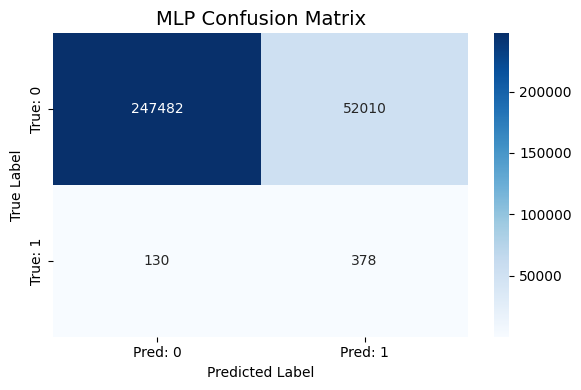

In [32]:
pipeline_mlp = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('under', RandomUnderSampler(random_state=42)),
    ('mlp', MLPClassifier(max_iter=300, random_state=42))
])

param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(32,), (64,), (64, 32)],
    'mlp__alpha': [0.0001, 0.001, 0.01]
}

grid_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv=5, scoring='f1_macro', n_jobs=-1)
grid_mlp.fit(X_train, y_train)

y_pred_mlp = grid_mlp.predict(X_test)

print("MLP Best Params:", grid_mlp.best_params_)
print(classification_report(y_test, y_pred_mlp))

cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: 0', 'Pred: 1'], 
            yticklabels=['True: 0', 'True: 1'])
plt.title("MLP Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### SVM

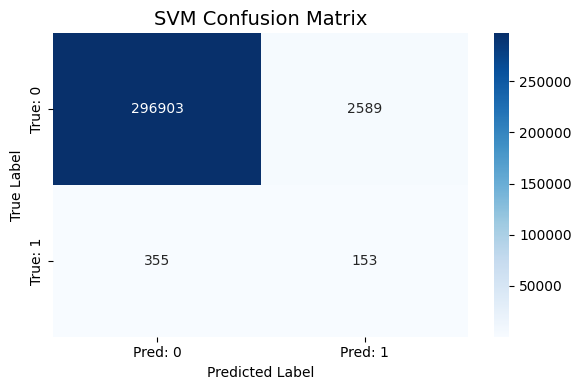

In [33]:
pipeline_svm = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('under', RandomUnderSampler(random_state=42)),
    ('svm', SVC(kernel='rbf'))
])

param_grid_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.01, 0.1, 1]
}

grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='f1_macro', n_jobs=-1)
grid_svm.fit(X_train, y_train)

y_pred_svm = grid_svm.predict(X_test)

print("SVM Best Params:", grid_svm.best_params_)
print(classification_report(y_test, y_pred_svm))
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: 0', 'Pred: 1'], 
            yticklabels=['True: 0', 'True: 1'])
plt.title("SVM Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


## KNN

KNN Best Params: {'knn__n_neighbors': 9}
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    299492
           1       0.01      0.77      0.01       508

    accuracy                           0.80    300000
   macro avg       0.50      0.79      0.45    300000
weighted avg       1.00      0.80      0.89    300000



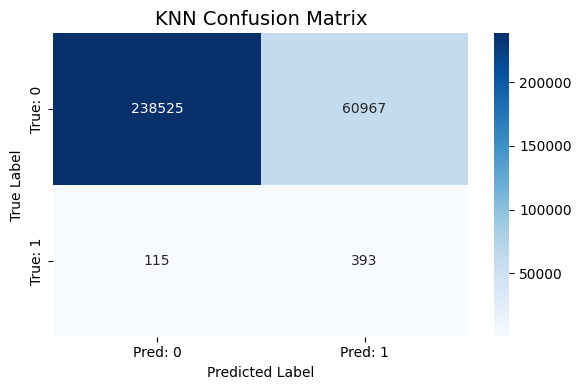

In [34]:
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('under', RandomUnderSampler(random_state=42)),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9]
}

grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='f1_macro', n_jobs=-1)
grid_knn.fit(X_train, y_train)

y_pred_knn = grid_knn.predict(X_test)

print("KNN Best Params:", grid_knn.best_params_)
print(classification_report(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: 0', 'Pred: 1'], 
            yticklabels=['True: 0', 'True: 1'])
plt.title("KNN Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
